In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


allowed_ext = ('.jpeg', '.jpg', '.bmp', '.png')
path_blood = 'Blood_Cells_Cancer/Blood_cell_Cancer'
path_brain = 'Data_Brain/Train'
IMG_SIZE = 224

images_blood = []
labels_blood = []



try:
   
        classes_blood = [d for d in os.listdir(path_blood) if os.path.isdir(os.path.join(path_blood, d))]
        print(classes_blood)
        for class_name in classes_blood:
            class_path = os.path.join(path_blood, class_name)
            
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(allowed_ext):
                    img_path = os.path.join(class_path, img_file)
                    img = cv2.imread(img_path)
                    
                    if img is not None:
                        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        images_blood.append(img_resized)
                        labels_blood.append(class_name)

except Exception as e:
    print(f"Une erreur est survenue: {e}")

Une erreur est survenue: [WinError 3] Le chemin d’accès spécifié est introuvable: 'Blood_Cells_Cancer/Blood_cell_Cancer'


In [3]:
len(labels_blood)

0

<Axes: >

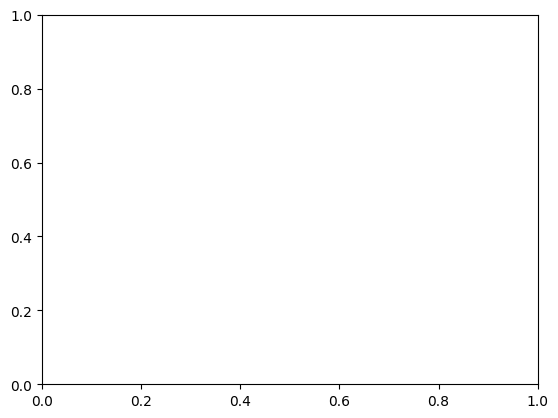

In [4]:
sns.countplot(x = labels_blood)

In [5]:
import numpy as np

labels_blood = np.array(labels_blood)
unique_classes = np.unique(labels_blood)
fig, axes = plt.subplots(len(unique_classes), 5, figsize=(15, len(unique_classes) * 3))

for i, class_name in enumerate(unique_classes):
    class_indices = np.where(labels_blood == class_name)[0][:5]
    print(class_indices)
    for j, idx in enumerate(class_indices):
        ax = axes[i, j] if len(unique_classes) > 1 else axes[j]
        img_rgb = cv2.cvtColor(images_blood[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'{class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(images_blood)
y = labels_blood

X_train , X_temp , y_train , y_temp = train_test_split(X , y , test_size=0.3 , random_state=42 , stratify=y)

X_test , X_val , y_test , y_val = train_test_split(X_temp , y_temp , test_size=0.5 , random_state=42 , stratify=y_temp)

In [ ]:
classes_blood

['Pro-B', 'Benign', 'Pre-B', 'early Pre-B']

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),               
    transforms.ToTensor(),                        # Conversion en tenseur [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f'data/Blood_Cells_Cancer/Blood_cell_Cancer', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# récupérer un batch
images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [ ]:
import torch.nn as nn
from torchvision import models

googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

num_features = googlenet.fc.in_features

num_classes = 4
googlenet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\reida/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100.0%


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=0.001)
